**Importing Libraries**

In [29]:
import zipfile
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [9]:
zip_file_path = '/content/data.zip'
extract_dir = '/content/extracted_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



 Load and Display Sample Audio
**bold text**

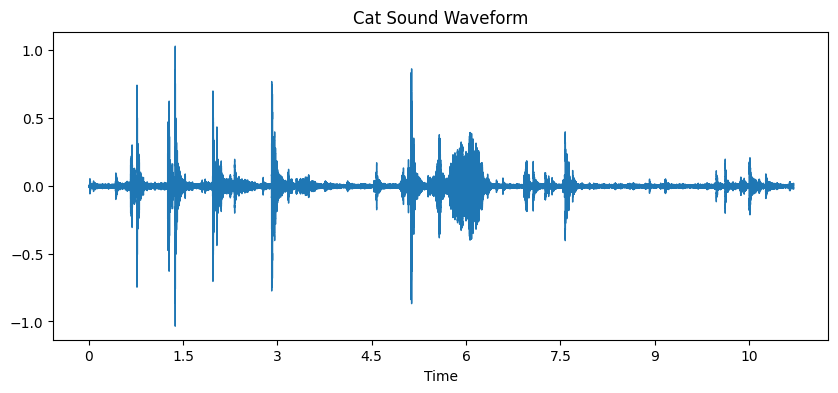

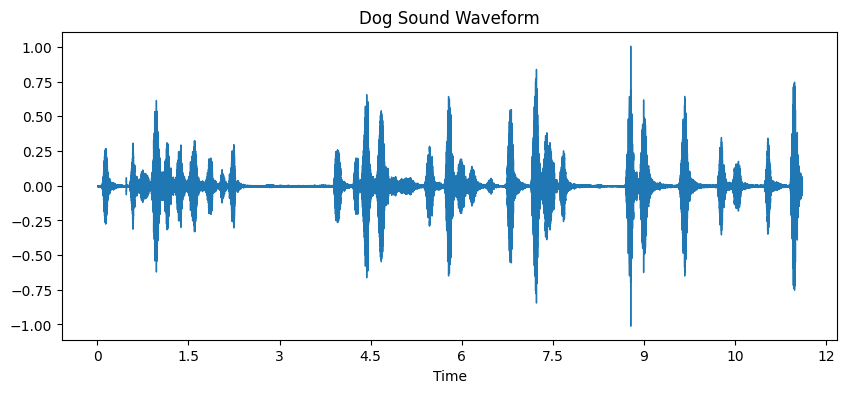

In [10]:
audio_dir = '/content/extracted_data/cats_dogs'
#loding the cat sound
cat_sound_path = os.path.join(audio_dir, 'cat_1.wav')
cat_audio, sr = librosa.load(cat_sound_path)

#Plotting the Cat Sound Waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(cat_audio, sr=sr)
plt.title('Cat Sound Waveform')
plt.show()

dog_sound_path = os.path.join(audio_dir, 'dog_barking_1.wav')
dog_audio, sr = librosa.load(dog_sound_path)
#dog sound waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(dog_audio, sr=sr)
plt.title('Dog Sound Waveform')
plt.show()


**Display Spectrograms**

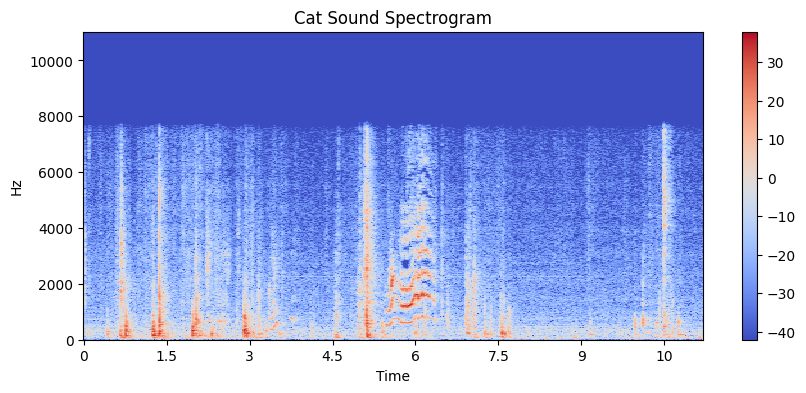

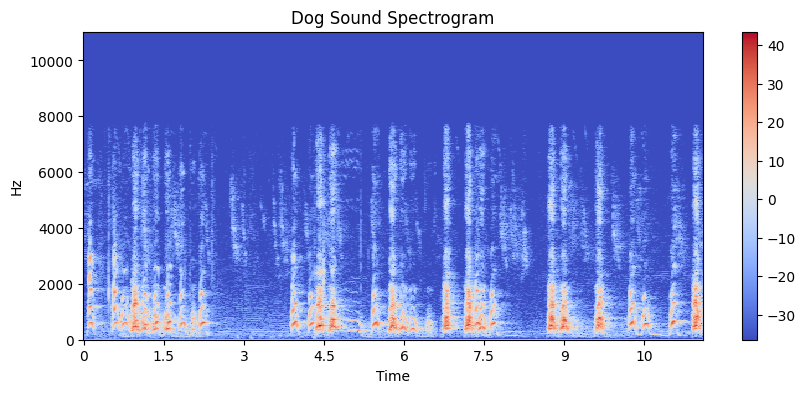

In [11]:
plt.figure(figsize=(10, 4))
X = librosa.stft(cat_audio)
Xdb = librosa.amplitude_to_db(abs(X)) # analyze the frequency over time
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Cat Sound Spectrogram')
plt.show()

plt.figure(figsize=(10, 4))
X = librosa.stft(dog_audio)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Dog Sound Spectrogram')
plt.show()








**Define Feature Extraction Function**

In [21]:
cats_dogs_dir = '/content/extracted_data/cats_dogs'
labels = []
features = []


for file_name in os.listdir(cats_dogs_dir):
    if file_name.endswith('.wav'):
        file_path = os.path.join(cats_dogs_dir, file_name)
        audio_data, sample_rate = librosa.load(file_path, sr=None)

        # Extract MFCC
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
        mfccs = np.mean(mfccs.T, axis=0)


        features.append(mfccs)
        if 'cat' in file_name:
            labels.append(0)  # 0 for cat
        elif 'dog' in file_name:
            labels.append(1)  # 1 for dog

X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Process and Augment Data**

In [22]:
def augment_audio(audio_data, sample_rate):
    # Time Stretching
    stretch_rate = np.random.uniform(0.8, 1.2)
    audio_stretched = librosa.effects.time_stretch(audio_data, rate=stretch_rate)


    # Pitch Shifting
    pitch_shift = np.random.randint(-2, 3)
    audio_shifted = librosa.effects.pitch_shift(audio_stretched, sr=sample_rate, n_steps=pitch_shift)

    # Adding Noise
    noise = np.random.randn(len(audio_shifted))
    audio_noisy = audio_shifted + 0.005 * noise

    # Shifting
    shift_max = np.random.randint(1, sample_rate)
    audio_shifted_time = np.roll(audio_noisy, shift_max)

    # Changing Volume
    audio_augmented = audio_shifted_time * np.random.uniform(0.8, 1.2)

    return audio_augmented



for file_name in os.listdir(cats_dogs_dir):
    if file_name.endswith('.wav'):
        file_path = os.path.join(cats_dogs_dir, file_name)
        audio_data, sample_rate = librosa.load(file_path, sr=None)

        audio_augmented = augment_audio(audio_data, sample_rate)

        augmented_file_path = os.path.join(cats_dogs_dir, 'aug_' + file_name)
        sf.write(augmented_file_path, audio_augmented, sample_rate)

Model Building and Evaluation








In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

Accuracy: 78.38%
              precision    recall  f1-score   support

         Cat       0.94      0.69      0.80        68
         Dog       0.66      0.93      0.77        43

    accuracy                           0.78       111
   macro avg       0.80      0.81      0.78       111
weighted avg       0.83      0.78      0.79       111



Model Building and Hyperparameter Tuning









In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64),
                    activation='relu',
                    solver='adam',
                    max_iter=1000,
                    alpha=0.0001,
                    learning_rate='adaptive')

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100:.2f}%')

Accuracy after tuning: 91.89%


 Model Evaluation (Confusion Matrix Visualization)

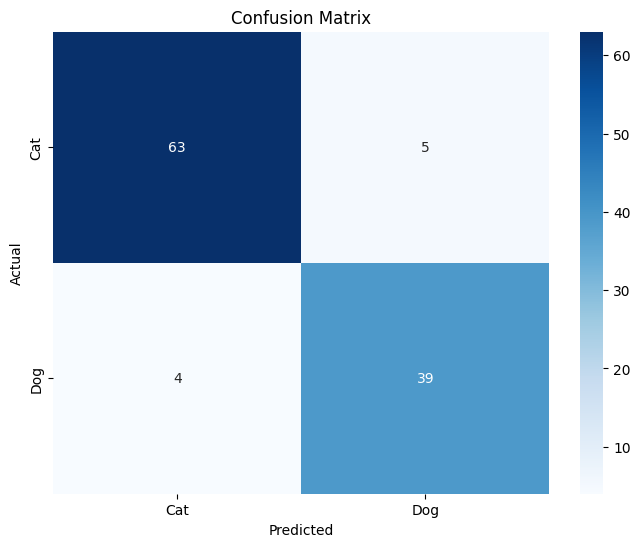

In [30]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Finally Classifying Multiple Audios**

In [33]:
def preprocess_audio(file_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs.reshape(1, -1)

new_audio_file = '/content/extracted_data/cats_dogs/aug_aug_cat_121.wav'
X_new = preprocess_audio(new_audio_file)

In [34]:
prediction = mlp.predict(X_new)

if prediction[0] == 0:
    print("The sound is from a Cat.")
else:
    print("The sound is from a Dog.")

The sound is from a Cat.
